In [1]:
#------------------- Import packages -------------------#
import os
from os import listdir
from os.path import isfile, join

# Data wrangling
import pandas as pd
import numpy as np

# Vizualizations
import matplotlib.pyplot as plt
import matplotlib.dates as matdates

import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as gobjects
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()


# Working with datetimes
import datetime
import time

# Utitlities
import yfinance as yf
import warnings
warnings.simplefilter('ignore')

# Constances

In [2]:
_DATAPATH_STOCKS = 'data/stocks/'
_DATAPATH_CRYPTO = 'data/crypto/'

startDate_str = '2017-01-01'
endDate_str = '2022-01-01'
SDATE = pd.to_datetime(startDate_str)
EDATE = pd.to_datetime(endDate_str)

# Loader Class | Download the Data

The loader class and other helper functions are used to download the data, control consistency of directories

In [3]:
def check_dir(*directories):
    '''
    If the directory doesn't exist, make it
    '''
    for dir in directories:
        if not os.path.exists(dir):
            os.makedirs(dir)
            print('{} directory was made'.format(dir))

In [5]:
class Loader:

    def __init__(self, dir):
        self.tickers = None
        self.num_downloads = 0
        self._dir = dir

    def get_tickers(self, file, column_name):
        '''
        The function takes a file and a column name as input, and returns a list of tickers
        
        :param file: the file that contains the tickers
        :param column_name: the name of the column that contains the tickers
        :return: A list of tickers.
        '''
        try:
            if 'csv' in file:
                df = pd.read_csv(file)
            else:
                df = pd.read_excel(file)
        except FileNotFoundError:
            print('There is no such file: {}'.format(file))
        else:
            self.tickers = df[column_name]
    
        return self.tickers

    def download_yahoo(self, period):
        '''
        It downloads the data from yahoo finance.
        
        :param period: the time period you want your Yahoo data to be in (i.e. '1d', '5d', '1mo', '3mo',
        '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
        '''
        
        def collect_data(folder, ticker, period):
            '''
            It takes in a ticker, a period, and a folder. It then tries to download the data from Yahoo
            Finance. If it fails, it prints out the ticker and returns 0. If it succeeds, it saves the
            data to the folder and returns 1
            
            :param folder: the folder where the data will be saved
            :param ticker: The ticker you want to pull data for
            :param period: The period used to define the data range. Valid periods are: 1d, 5d, 1mo,
            3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
            :return: a 1 if the data was successfully collected and a 0 if it was not.
            '''
            asset = yf.Ticker(ticker)

            try:
                df = asset.history(period = period)
                if df.shape[0] == 0:
                    return 0
                else:
                    savedFile = folder + ticker.replace('.', '_') + '.csv'
                    df.to_csv(savedFile)
                    return 1

            except:
                print('Unsuccessful: {}'.format(ticker))
                return 0

        for ticker in self.tickers:
            self.num_downloads += collect_data(self._dir, ticker, period)
        
        print('{} assets were downloaded'.format(self.num_downloads))

        

# Post-process the data

Calculate all returns, indicators, std, etc.

In [6]:
def post_process(dir):
    '''
    Post process the data in a given directory.
    Get the filenames in the directory and extract/format the tickers.
    Calculate returns, indicators, etc.
    
    :param dir: The directory where the CSV files are located
    '''

    def create_df(ticker):
        '''
        Create a dataframe from a CSV file. If the CSV file does not exist, print an error message
        
        :param ticker: the stock ticker symbol
        :return: A dataframe
        '''
        try: 
            df = pd.read_csv(dir + ticker + '.csv')
        except FileNotFoundError:
            print('CSV for {} does not exist'.format(ticker))
        else:
            return df

    def calculate_daily_return(df):
        df['return_daily'] = (df['Close'] / df['Close'].shift(1)) - 1
        return df
    
    def calculate_cummulative_return(df):
        df['return_cummulative'] = (1 + df['return_daily']).cumprod()
        return df

    def calculate_bollinger_bands(df):
        '''
        Calculate the Bollinger Bands for a stock
        
        :param df: The dataframe to which we want to apply the Bollinger Band calculation
        :return: a dataframe with the new columns.
        '''
        df['band_baseline'] = df['Close'].rolling(window = 20).mean()
        df['band_upper'] = df['band_baseline'] + 1.96 * df['Close'].rolling(window = 20).std()
        df['band_lower'] = df['band_baseline'] - 1.96 * df['Close'].rolling(window = 20).std()
        return df

    def calculate_ichimoku(df):
        '''
        Calculate the conversion line, base line, and lagging span for the dataframe
        
        :param df: The DataFrame you wish to add the indicator to
        :return: the dataframe with the new columns added.
        '''

        # Conversion Line = (Highest Value in period + Lowest value in period)/2 (9 Sessions)
        valueH_9 = df['High'].rolling(window = 9).max()
        valueL_9 = df['Low'].rolling(window = 9).max()
        df['Conversion'] = (valueH_9 + valueL_9)/2

        # Base Line = (Highest Value in period + Lowest value in period)/2 (26 Sessions)
        valueH_26 = df['High'].rolling(window = 26).max()
        valueL_26 = df['Low'].rolling(window = 26).max()
        df['Baseline'] = (valueH_26 + valueL_26)/2

        # Span A = (Conversion Value + Base Value)/2 (26 Sessions)
        df['Span A'] = ((df['Conversion'] + df['Baseline']) / 2)

        # Span B = (Conversion Value + Base Value)/2 (52 Sessions)
        valueH_52 = df['High'].rolling(window = 52).max()
        valueL_52 = df['Low'].rolling(window = 52).max()
        df['Span B'] = ((valueH_52 + valueL_52) / 2).shift(26)

        # Lagging Span = Price shifted back 26 periods
        df['Lagging Span'] = df['Close'].shift(-26)

        return df

    tickers = [file.split('.')[0] for file in listdir(dir) if isfile(join(dir, file))]   

    for ticker in tickers:
        try:
            df_new = create_df(ticker)
            df_new = calculate_daily_return(df_new)
            df_new = calculate_cummulative_return(df_new)
            df_new = calculate_bollinger_bands(df_new)
            df_new = calculate_ichimoku(df_new)
            df_new.to_csv(dir + ticker + '.csv')
        except Exception as ex:
            print(ex) 

# Asset class

In [12]:
class Asset:

    def __init__(self, ticker):
        
        try:
            self.data = pd.read_csv(_DATAPATH_STOCKS + ticker + '.csv')
            self.data.set_index(['Date'], inplace = True)
        except FileNotFoundError:
            print('CSV for {} does not exist'.format(ticker))
        except: 
            self.data = pd.read_csv(_DATAPATH_CRYPTO + ticker + '.csv')
            self.data.set_index(['Date'], inplace = True)
        
        self.name = ticker

    def plot_boll_bands(self, slider = True):
        '''
        It plots the bollinger bands for the stock
        
        :param slider: If True, the plot will have a RangeSlider under the X-axis to allow the user to
        change the time period being plotted, defaults to True (optional)
        '''
        fig = gobjects.Figure()

        candle = gobjects.Candlestick(x = self.data.index, open = self.data['Open'], high = self.data['High'], low = self.data['Low'], close = self.data['Close'], name = 'Candlestick')

        middlerBand = gobjects.Scatter(x = self.data.index, y = self.data['band_baseline'], line = dict(color = 'rgba(0, 0, 250, 0.75)', width = 0.8), name = 'Middle Band')
        upperBand = gobjects.Scatter(x = self.data.index, y = self.data['band_upper'], line = dict(color = 'rgba(250, 0, 0, 0.75)', width = 1), name = 'Upper Band')
        lowerBand = gobjects.Scatter(x = self.data.index, y = self.data['band_lower'], line = dict(color = 'rgba(0, 250, 0, 0.75)', width = 1), name = 'Lower Band')

        fig.add_trace(candle)
        fig.add_trace(middlerBand)
        fig.add_trace(upperBand)
        fig.add_trace(lowerBand)

        fig.update_xaxes(title = 'Date', rangeslider_visible = slider)
        fig.update_yaxes(title = 'Price')

        fig.update_layout(title = self.name + ' Bollinger Bands', height = 600, width = 900, showlegend = True)
        fig.show()

    def plot_ichimoku(self, slider = True):
        '''
        This function plots the Ichimoku Cloud
        
        :param slider: If True, a slider will be shown on the plot which allows the user to change the time
        period being shown in the plot, defaults to True (optional)
        '''
        # As spans are going to cross eac hother, we need to change the ccolors accordingly
        def get_color_on_cross(flag):
            if flag >= 1:
                return 'rgba(0, 250, 0, 0.4)'

            return 'rgba(250, 0, 0, 0.4)'
        
        candle = gobjects.Candlestick(x = self.data.index, open = self.data['Open'], high = self.data['High'], low = self.data['Low'], close = self.data['Close'], name = 'Candlestick')

        df_new = self.data.copy()
        fig = gobjects.Figure()
        self.data['Flag'] = np.where(self.data['Span A'] > self.data['Span B'], 1, 0)
        self.data['Group'] = self.data['Flag'].ne(self.data['Flag'].shift()).cumsum()
        df = self.data.groupby('Group')

        newList = []
        for name, data in df:
            newList.append(data)

        for df in newList:
            fig.add_traces(gobjects.Scatter(x = df.index, y = df['Span A'], line = dict( color = 'rgba(0,0,0,0)')))
            fig.add_traces(gobjects.Scatter(x = df.index, y = df['Span B'], line = dict( color = 'rgba(0,0,0,0)'), fill = 'tonexty', fillcolor = get_color_on_cross(df['Flag'].iloc[0])))

        baseline = gobjects.Scatter(x = df_new.index, y = df_new['Baseline'], line = dict(color = 'pink', width = 2), name = 'Baseline')
        conversion = gobjects.Scatter(x = df_new.index, y = df_new['Conversion'], line = dict(color = 'black', width = 1), name = 'Conversion')
        lagging = gobjects.Scatter(x = df_new.index, y = df_new['Lagging Span'], line = dict(color = 'purple', width = 2), name = 'Lagging Span')
        spanA = gobjects.Scatter(x = df_new.index, y = df_new['Span A'], line = dict(color = 'green', width = 2, dash = 'dot'), name = 'Span A')
        spanB = gobjects.Scatter(x = df_new.index, y = df_new['Span B'], line = dict(color = 'red', width = 2, dash = 'dot'), name = 'Span B')

        fig.add_trace(candle)
        fig.add_trace(baseline)
        fig.add_trace(conversion)
        fig.add_trace(lagging)
        fig.add_trace(spanA)
        fig.add_trace(spanB)
        fig.update_xaxes(title = 'Date', rangeslider_visible = slider)
        fig.update_yaxes(title = 'Price')
        fig.update_layout(height = 600, width = 900, showlegend = True)
        fig.show()
        

# Drive Code

In [8]:
# Check the directory, download and process the data

check_dir(_DATAPATH_STOCKS, _DATAPATH_CRYPTO)
loader = Loader(_DATAPATH_STOCKS)
tickers = loader.get_tickers('SP500.csv', 'Symbol')
loader.download_yahoo('5y')

post_process(_DATAPATH_STOCKS)

data/stocks/ directory was made
- ALXN: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- APC: No data found, symbol may be delisted
- BHGE: No data found, symbol may be delisted
- BBT: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- COG: No data found, symbol may be delisted
- CBG: No data found for this date range, symbol may be delisted
- CBS: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- XEC: No data found, symbol may be delisted
- CXO: No data found, symbol may be delisted
- DWDP: No data found, symbol may be delisted
- DPS: No data found for this date range, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- GGP: No data found for this date range, symbol may be delisted
- HRS: No data found, sy

In [13]:
amd = Asset('AMD')
amd.plot_boll_bands()

In [14]:
amd.plot_ichimoku()

# Portfolio Optimization

In [39]:
class Portfolio:

    def __init__(self, tickers:list):
        self.tickers = tickers
        self.size = len(tickers)

        # To store price and cummulative returns in merged dataframe
        self.data = None
        self.cummulative = None

        # Pure returns of the portfolio before weighting
        self.returns = None
        self.returns_mean = None
        
        # Attributes for optimized portfolio
        self.weights = None
        self.volatility = None
        self.sharpeRatio = None
        self.return_optimized = None

    def generate_table(self, column_name, sdate, edate):
        df_result = pd.DataFrame()
    
        for ticker in self.tickers:
            try:
                df = pd.read_csv(_DATAPATH_STOCKS + ticker + '.csv')
                df.set_index(['Date'], inplace = True)
            except FileNotFoundError:
                print('CSV for {} does not exist'.format(ticker))
            except: 
                df = pd.read_csv(_DATAPATH_CRYPTO + ticker + '.csv')
                df.set_index(['Date'], inplace = True)
                
            mask = (df.index >= sdate) & (df.index <= edate)
            df_result[ticker] = df.loc[mask][column_name]
            
        if column_name == 'Close':
            self.data = df_result

        else: self.cummulative = df_result

    def plot_graph(self, type,  slider = True):
        if type == 'Price':
            fig = px.line(self.data, x = self.data.index, y = self.data.columns)
        else:
            fig = px.line(self.cummulative, x = self.cummulative.index, y = self.cummulative.columns)
        
        fig.update_xaxes(title = "Date", rangeslider_visible=slider)
        fig.update_yaxes(title = type)
        fig.update_layout(height=600, width=900, 
                        showlegend=True)
        fig.show()

    def calculate_returns(self):
        self.returns = np.log(self.data / self.data.shift(1))
        self.returns_mean = self.returns.mean() * 252

    def show_correlation_table(self):
        print(self.returns.corr())

    def optimize_weightings(self, sharpe_ratio = 0.01, N = 10000, plot_frontier = True):
        returnsSpace = [] # Returns list
        volatilitySpace = [] # Volatility list
        sharpeRatioSpace = [] # Sharpe Ratio list
        weightsSpace = [] # Stock weights list


        for x in range(N):
            # Generate random weights
            p_weights = np.random.random(self.size)
            p_weights /= np.sum(p_weights)
            
            # Add return using those weights to list
            returnsSpace.append( (np.sum(p_weights * self.returns.mean()) * 252) )
            
            # Add volatility or standard deviation to list
            volatilitySpace.append( np.sqrt(np.dot(p_weights.T, np.dot(self.returns.cov() * 252, p_weights))) )
            
            # Get Sharpe ratio
            SR = (returnsSpace[-1] - returnsSpace) / volatilitySpace[-1]
            sharpeRatioSpace.append(SR)
            
            # Store the weights for each portfolio
            weightsSpace.append(p_weights)
            
        # Convert to Numpy arrays
        returnsSpace = np.array(returnsSpace)
        volatilitySpace = np.array(volatilitySpace)
        sharpeRatioSpace = np.array(sharpeRatioSpace)
        weightsSpace = np.array(weightsSpace)

        if plot_frontier == True:
            ports = pd.DataFrame({'Return': returnsSpace, 'Volatility': volatilitySpace})

            ports.plot(x = 'Volatility', y='Return', kind='scatter', figsize=(16, 9))

        
        idx_best = np.argmax(SR)
        self.volatility = volatilitySpace[idx_best]
        self.weights = weightsSpace[idx_best]
        self.return_optimized = returnsSpace[idx_best]
        self.sharpeRatio = sharpeRatioSpace[idx_best]

    def show_optimized_portfolio(self):

        for i in range(len(self.tickers)):
            print('{}: {:.0%}'.format(self.tickers[i], self.weights[i]))

        print('\nVolatility: {}'.format(self.volatility))
        print('Return     : {}'.format(self.return_optimized))

RMD: 0%
AAPL: 1%
DFS: 19%
FTV: 7%
AMD: 0%
GPS: 20%
GPC: 14%
MDT: 9%
MET: 16%
NKE: 0%
RCL: 13%

Volatility: 0.33573589165788414

Return     : 0.06631134702387541


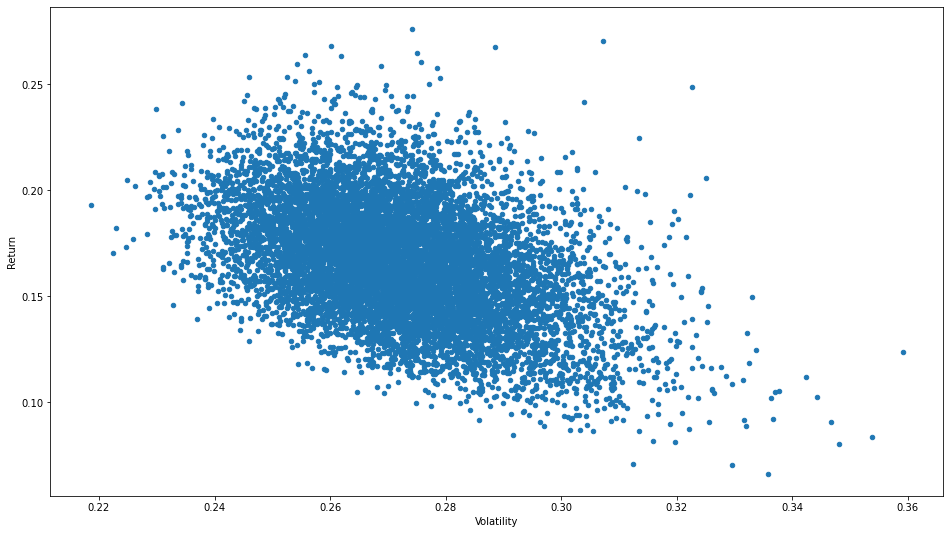

In [38]:
port_list = ['RMD', 'AAPL', 'DFS', 'FTV',
'AMD', 'GPS', 'GPC', 'MDT', 'MET',
'NKE', 'RCL']
port = Portfolio(port_list)
port.generate_table('Close',  startDate_str, endDate_str)
port.generate_table('return_cummulative',  startDate_str, endDate_str)
port.calculate_returns()
port.optimize_weightings(plot_frontier = True)

In [36]:
port.weights[2]

0.05148162689692883